<div class="alert alert-block alert-info">
    <h2><center>Estimación de la desviación de precios del sistema eléctrico chileno</center></h2>
    <center>Descripción: Estimación de la desviación de los costos marginales en distintos nodos del sistema, entendiendo qué variables son las que más afectan su comportamiento y cómo esto podría ser útil para la eficiencia del sistema.</center>
</div>

In [4]:
###
# Bibliotecas
###
#Manejo de datos
import pandas as pd
#Bibliotecas cientificas
from sklearn import tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import export_text
from sklearn.preprocessing import MinMaxScaler
#Computo matricial y númerico
import numpy as np
#Visualizacion
import plotly
import plotly.graph_objects as go
import plotly.express as px
#Utilidades
from datetime import datetime
#Bibliotecas de modelado
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Input,Dropout, concatenate, LSTM
from keras.optimizers import Adam
from keras.models import Model

In [ ]:
#Se uso google colab para el entrenamiento
from google.colab import drive
drive.mount('/content/drive')

# Contexto

## Desafío
En este desafío estimaremos la desviación de precios del sistema eléctrico chileno. Específicamente, estimaremos la desviación de los costos marginales en distintos nodos del sistema, entendiendo qué variables son las que más afectan su comportamiento y cómo esto podría ser útil para la eficiencia del sistema. Para ello, hemos construido un dataset usando datos públicos y reales del sistema eléctrico de Chile.

Algunas definiciones importantes:

**Sistema Eléctrico**: Conjunto de instalaciones de centrales eléctricas generadoras, líneas de transporte, subestaciones eléctricas, líneas de distribución, interconectadas entre sí, que permite generar, transportar y distribuir energía eléctrica.

**Subestación**: Conjunto de instalaciones eléctricas (transformadores, aisladores, interruptores, etc) y de infraestructura (terreno, edificio, etc), que sirven para transferir energía, transformar voltajes, recibir y entregar energía y suministrar electricidad a consumos.

**Barra Principal**: Es un tramo de conductores aislados, donde convergen líneas de transmisión, alimentación a bancos de autotransformadores y transformadores de poder que retiran o inyectan energía a la barra, permitiendo el traspaso de flujos de potencias entre las líneas. Si tienes dudas, puedes consultar el glosario del SIC (Sistema Interconectado Central) en https://sic.coordinador.cl/wp-content/uploads/2013/12/MP_Glosario_CDEC-SIC.pdf

- Nivel de observación: día-hora y subestación (cada fila es una subestación y día-hora).

    - nemotecnico_se: código subestación eléctrica

    - fecha, hora: año, mes, día y hora.

    - gen_eolica_total_mwh: generación eólica total por subestación en MWh

    - gen_geotermica_total_mwh: generación geotérmica total por subestación en MWh

    - gen_hidraulica_total_mwh: generación hidráulica total por subestación en MWh

    - gen_solar_total_mwh: generación solar total por subestación en MWh

    - gen_termica_total_mwh: generación térmica total por subestación en MWh

    - cmg_real: costo marginal real [USD/MWh] promedio por subestación

    - cmg_prog: costo marginal programado [USD/MWh] promedio por subestación

    - cmg_desv: desviación absoluta promedio entre costo marginal programado y costo marginal real

    - cmg_desv_pct: desviación porcentual promedio del costo marginal real con respecto al costo marginal programado

    - n_barras: número de barras conectadas aguas abajo de una subestación

    - demanda_mwh: retiros de energía [MWh] efectuados por compañías coordinadas bajo el sistema eléctrico

    - cap_inst_mw: capacidad de generación máxima instalada por subestación [MW]

## Carga de los datos

Instrucciones:

- Carga el archivo costo_marginal_real.csv. Estos son los costos marginales reales observados.
- Carga el archivo costo_marginal_programado.csv. Estos son los costos marginales previstos por el sistema.

In [6]:
#Cargar archivos como variables privadas
_costo_marginal_programado_df = pd.read_csv (r'/content/drive/My Drive/Datasets/costo_marginal_programado.csv')
_base_prediccion_df = pd.read_csv (r'/content/drive/My Drive/Datasets/base_para_prediccion.csv')
_costo_marginal_real_df = pd.read_csv(r'/content/drive/My Drive/Datasets/costo_marginal_real.csv')
_demanda_real_df = pd.read_csv(r'/content/drive/My Drive/Datasets/demanda_real.csv')
_datos_clima_df = pd.read_csv(r'/content/drive/My Drive/Datasets/datos_clima.csv')

## Análisis de los datos

In [7]:
#Buscar valores missing
print('Costo marginal programado total:{} \n Valores NAN: \n{}'.format(len(_costo_marginal_programado_df),_costo_marginal_programado_df.isnull().sum()))
print('\nCosto marginal real total:{} \n Valores NAN: \n {}'.format(len(_costo_marginal_real_df),_costo_marginal_real_df.isnull().sum()))
print('\nBase para predicción: {} \n Valores NAN: \n{}'.format(len(_base_prediccion_df),_base_prediccion_df.isnull().sum()))
#print('\nDemanda real: {} \n Valores NAN: \n {}'.format(len(_demanda_real_df),_demanda_real_df.isnull().sum()))
print('\nDatos de clima: {} \n Valores NAN: \n{}'.format(len(_datos_clima_df),_datos_clima_df.isnull().sum()))


Costo marginal programado total:1192124 
 Valores NAN: 
mnemotecnico_barra    0
nombre_barra          0
fecha                 0
hora                  0
costo                 0
dtype: int64

Costo marginal real total:4309951 
 Valores NAN: 
 barra_mnemotecnico               0
barra_referencia_mnemotecnico    0
fecha                            0
hora                             0
costo_en_dolares                 0
costo_en_pesos                   0
nombre                           0
dtype: int64

Base para predicción: 112779 
 Valores NAN: 
nemotecnico_se                   0
fecha                            0
hora                             0
gen_eolica_total_mwh        112779
gen_geotermica_total_mwh    112779
gen_hidraulica_total_mwh     78595
gen_solar_total_mwh          70961
gen_termica_total_mwh        50916
cmg_real                         0
cmg_prog                         0
cmg_desv                         0
cmg_desv_pct                     0
n_barras                         0


In [9]:
#Análisis de los ID's
#Analisis de la distribución de barras agrupados por su nombre

#Tabla del costo marginal programado
_costo_marginal_programado_df.\
groupby(['mnemotecnico_barra'])['mnemotecnico_barra'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos',ascending=False)

,mnemotecnico_barra,Contador_Unicos
0,-,180115
66,BA01T002SE036T002,8690
114,BA02T003SE004T003,8690
225,BA83L131SE134L131,7538
134,BA03T002SE026T002,4345
...,...,...
203,BA47T005SE021G216,3769
173,BA22L120SE079L120,3769
205,BA51G226SE091G226,3769
206,BA52G216SE023G216,3769


In [10]:
#Tabla del costo marginal real agrupando sus elementos por su nombre
_costo_marginal_real_df.\
groupby(['barra_mnemotecnico'])['barra_mnemotecnico'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos',ascending=False)

,barra_mnemotecnico,Contador_Unicos
0,BA01G004SE001T011,4345
644,BA02T005SE185T005,4345
646,BA02T005SE188T005,4345
647,BA02T005SE189T005,4345
648,BA02T005SE190T005,4345
...,...,...
927,BA42G216SE187G216,1464
999,BA87T005SE275T005,744
971,BA65T005SE277T005,744
957,BA56T005SE276T005,744


In [11]:
_datos_clima_df.\
groupby(['subestacion'])['subestacion'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos',ascending=False)

,subestacion,Contador_Unicos
0,SE001T002,181
15,SE031G216,181
27,SE127T005,181
26,SE123G216,181
25,SE106G216,181
24,SE103L123,181
23,SE082T005,181
22,SE081T005,181
21,SE071T005,181
20,SE067T005,181


<div class="alert alert-block alert-warning">
    <h3><center>Observaciones</center></h3>
    <p align="right"/>
        <ul style="list-style-type:square">
        <li> Se puede observar que hay valores nan en la tabla de 'Base para predicción', además 2 de las columnas son solo valores nan.</li>
        <li> Además, en la tabla de costos marginales programados se observa un caracter '-' que simplemente genera ruido en la tabla, por lo que habrá que eliminarlos</li>
        <li>La tabla de costos marginales parece ser mas homogenea, puesto que no se observan valores nan ni tampoco hay valores 'missing' en sus id's</li>
        <li>Para la tabla de datos del clima tampoco se observaron valores nan y la distribución de las subestaciones es perfectamente homogenea
        </ul>

</div>


In [12]:
#Borrar filas con valores missing '-' en la tabla de costos marginales programados
print('Total de filas antes de eliminar missings: {}'.format(len(_costo_marginal_programado_df)))
_costo_marginal_prog_clean = _costo_marginal_programado_df.drop(_costo_marginal_programado_df[_costo_marginal_programado_df['mnemotecnico_barra']=='-'].index)
print('Total de filas después de eliminar missings: {}'.format(len(_costo_marginal_prog_clean)))


Total de filas antes de eliminar missings: 1192124
Total de filas después de eliminar missings: 1012009


In [13]:
#Busqueda de duplicados

_costo_marginal_prog_clean = _costo_marginal_prog_clean.drop_duplicates(subset=['mnemotecnico_barra', 'fecha','hora'])
_costo_marginal_real_df = _costo_marginal_real_df.drop_duplicates(subset=['barra_mnemotecnico', 'fecha','hora'])

print('Total de filas después de eliminar duplicados en costos marginales programdos: {}'.format(len(_costo_marginal_prog_clean)))
print('Total de filas después de eliminar duplicados en costos marginales reales: {} NO HAY DUPLICADOS EN ESTA TABLA'.format(len(_costo_marginal_real_df)))



Total de filas después de eliminar duplicados en costos marginales programdos: 999550
Total de filas después de eliminar duplicados en costos marginales reales: 4309951 NO HAY DUPLICADOS EN ESTA TABLA


### 1. Costos Marginales

Instrucciones:

Haz un merge del costos marginal real con el costo marginal programado a nivel de barra (*Ayuda: la columna de join no se llama igual en ambas bases! Los datos venían así del SIC *). Llama a esta nueva base costo_marginal

In [14]:
_costo_marginal_prog_clean.tail()

,mnemotecnico_barra,nombre_barra,fecha,hora,costo
1192095,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,20,52.319394
1192096,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,21,53.165387
1192097,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,22,53.219271
1192098,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,23,52.936222
1192099,BA83L131SE134L131,BA S/E SIERRA GORDA 220KV - BP1,2019-06-06,24,51.328911


In [15]:
#Se observa una hora 25
_costo_marginal_real_df.head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1


In [16]:
_costo_marginal_real_df.\
groupby(['hora'])['hora'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos')

,hora,Contador_Unicos
24,25,991
22,23,179540
21,22,179540
20,21,179540
19,20,179540
18,19,179540
17,18,179540
16,17,179540
15,16,179540
14,15,179540


La hora 25 parece ser un dato anómalo y no agrega información relevante, además es el único dato desvalanceado de la tabla

In [17]:
#Eliminar dato de hora 25
_costo_marginal_real_clean = _costo_marginal_real_df.drop(_costo_marginal_real_df\
                                                                [_costo_marginal_real_df\
                                                                 ['hora']==25].index)
print('Tabla de costo marginal antes de elimnar la hora 25: {}\n'\
     'Tabla de costo marginal después de elimnar la hora 25: {}'.format(len(_costo_marginal_real_df),len(_costo_marginal_real_clean)))


Tabla de costo marginal antes de elimnar la hora 25: 4309951
Tabla de costo marginal después de elimnar la hora 25: 4308960


<div class="alert alert-block alert-warning">
    <h3><center>Observaciones</center></h3>
    <p align="right"/>
        <ul style="list-style-type:square">
        <li> Hay 1020 barras en reales en total y solo hay 238 barras en la tabla de costo marginal programado</li>
        <li> A partir de aquí se tiene que averiguar si las 238 barras que estan programadas también aparecen en la tabla de las barras de los costos marginales reales, es decir, las barras programadas deben ser un subconjunto de las reales</li>
        <li>Se debe cambiar los nombres de los Id's (columna: mnemotecnico_barra) en la tabla costo marginal programado para hacer coincidir el nombre de las barras con la tabla de costos marginal real así poder hacer la mezcla</li>
        <li>Por último se deben elegir los atributos de tabla mas relevantes para el análisis</li>
        </ul>

</div>




In [18]:
#Cambiar nombre de la llave para hacer coincidir en la indexación
_costo_marginal_prog_clean = _costo_marginal_prog_clean.rename(columns = {'mnemotecnico_barra':'barra_mnemotecnico'})

#Descomponer la tabla de costo_marginal_real y costo_marginal_prog_clean para elegir los atributos mas relevantes
_costo_marginal_real_ = _costo_marginal_real_clean[['barra_mnemotecnico','fecha','hora','costo_en_pesos']]
#Cambiar el nombre del costo
_costo_marginal_real_ = _costo_marginal_real_.rename(columns = {'costo_en_pesos':'costo_real'})

_costo_marginal_prog_ = _costo_marginal_prog_clean[['barra_mnemotecnico','fecha','hora','costo']]
_costo_marginal_prog_ = _costo_marginal_prog_.rename(columns = {'costo':'costo_programado'})

print(_costo_marginal_prog_.columns)
print(_costo_marginal_real_.columns)


Index(['barra_mnemotecnico', 'fecha', 'hora', 'costo_programado'], dtype='object')
Index(['barra_mnemotecnico', 'fecha', 'hora', 'costo_real'], dtype='object')


<div class="alert alert-block alert-warning">
 <p align="right"/>
    Para saber si todas las barras programadas estan en la tabla de barras reales voy a cruzar las tablas a partir del nombre de la tabla, esto se hará convirtiendo la columna 'barra_mnemotecnico' de la tabla _costos_marginales_programados en una lista y realizar una busqueda de los elementos de esa lista en la tabla de _costos_marginales_reales
</div> 

In [19]:
#Extraer lista de barras
lista_barra_prog = _costo_marginal_prog_.barra_mnemotecnico.to_list()

In [20]:
_costo_marginal_real_.\
groupby(['barra_mnemotecnico'])['barra_mnemotecnico'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos',ascending=False)

,barra_mnemotecnico,Contador_Unicos
0,BA01G004SE001T011,4344
644,BA02T005SE185T005,4344
646,BA02T005SE188T005,4344
647,BA02T005SE189T005,4344
648,BA02T005SE190T005,4344
...,...,...
927,BA42G216SE187G216,1464
999,BA87T005SE275T005,744
971,BA65T005SE277T005,744
957,BA56T005SE276T005,744


In [21]:
#Buscar en la tabla _costo_marginal_real_ las barras que coinciden con 
#la lista de barras de la tabla de costo_marginal_programado
coincidencias_real = _costo_marginal_real_.loc[
    _costo_marginal_real_.barra_mnemotecnico.isin(lista_barra_prog),:]
coincidencias_real

,barra_mnemotecnico,fecha,hora,costo_real
992,BA02T005SE081T005,2019-01-24,1,42.16415
998,BA01R002SE041R002,2019-01-24,1,36.86002
1003,BA01G132SE001G132,2019-01-24,1,36.83985
1005,BA56G216SE023G216,2019-01-24,1,40.41627
1006,BA68T005SE277T005,2019-01-24,1,40.55072
...,...,...,...,...
4309928,BA05T005SE288T005,2019-01-23,24,42.79953
4309931,BA01L081SE066L081,2019-01-23,24,49.20770
4309936,BA04T005SE071T005,2019-01-23,24,45.18662
4309945,BA01L079SE004L079,2019-01-23,24,52.18652


In [22]:
#Tamaño de las tablas después de aplicar los cambios
print(coincidencias_real.shape,_costo_marginal_prog_.shape)

(929520, 4) (999550, 4)


In [23]:
#Mezcla de los datos
costo_marginal = pd.merge(
    _costo_marginal_prog_, #izquierda
    coincidencias_real, #derecha
    on=['barra_mnemotecnico','fecha','hora'], #atributo de union
    how='inner'
)
costo_marginal

,barra_mnemotecnico,fecha,hora,costo_programado,costo_real
0,BA01T002SE002T002,2019-01-01,1,49.897334,34.89581
1,BA01T002SE002T002,2019-01-01,2,50.471616,34.89581
2,BA01T002SE002T002,2019-01-01,3,50.077821,34.19316
3,BA01T002SE002T002,2019-01-01,4,49.796216,33.61574
4,BA01T002SE002T002,2019-01-01,5,49.796216,32.19653
...,...,...,...,...,...
900715,BA83L131SE134L131,2019-06-06,20,52.319394,34.18403
900716,BA83L131SE134L131,2019-06-06,21,53.165387,34.18403
900717,BA83L131SE134L131,2019-06-06,22,53.219271,34.18403
900718,BA83L131SE134L131,2019-06-06,23,52.936222,32.18427


In [24]:
costo_marginal.\
groupby(['barra_mnemotecnico'])['barra_mnemotecnico'].\
count().\
reset_index(name='Contador_Unicos').\
sort_values(by='Contador_Unicos',ascending=False)

,barra_mnemotecnico,Contador_Unicos
0,BA01G004SE001T011,4344
121,BA03T002SE026T002,4344
113,BA03G010SE001G010,4344
114,BA03G010SE054G010,4344
115,BA03G011SE001G011,4344
...,...,...
81,BA01T005SE284T005,2160
3,BA01G004SE035G004,2160
90,BA01T038SE001G130,2160
173,BA38T005SE282T005,2160


In [25]:
costo_marginal.describe()

,hora,costo_programado,costo_real
count,900720.00000,900720.000000,900720.000000
mean,12.50000,61.911869,39.509093
std,6.92219,23.872680,15.590217
min,1.00000,-12.113677,0.000000
25%,6.75000,49.979576,32.552700
50%,12.50000,55.064828,35.965350
75%,18.25000,64.208912,41.253620
max,24.00000,610.600000,523.418220


In [26]:
_costo_marginal_real_.describe()

,hora,costo_real
count,4.308960e+06,4.308960e+06
mean,1.250000e+01,4.300023e+01
std,6.922187e+00,1.865194e+01
min,1.000000e+00,0.000000e+00
25%,6.750000e+00,3.410603e+01
50%,1.250000e+01,3.799040e+01
75%,1.825000e+01,4.471959e+01
max,2.400000e+01,7.343561e+02


In [27]:
_costo_marginal_prog_.describe()

,hora,costo_programado
count,999550.000000,999550.000000
mean,12.502976,61.983125
std,6.924052,24.013881
min,1.000000,-53.184778
25%,7.000000,50.011312
50%,13.000000,55.139559
75%,19.000000,64.265304
max,25.000000,610.600000


<div class="alert alert-success" role="alert">
    <h2>Análisis</h2>
    <ul style="list-style-type:square">
        <li> Realiza un análisis exploratorio de la base resultante</li>
        <li> ¿Qué puedes decir de las distintas variables?</li>
        <ul>
                <li>No todas las variables sirven para realizar un análisis, en la columna hora, encontre una hora 25, la cual fue borrada.</li>
            <li>Para cruzar las tablas, fue necesario encontrar que el ID (el atributo barra_mnemotecnico) fuera igual en ambas tablas</li>
            <li>También, fue necesario eliminar algunos atributos que no aportaban informacion al análisis, por ejemplo en la tabla de costos marginales reales,el atributo 'barra_referencia_mnemotecnico' era único valor repetido</li>
            <li>La columna de costo en dolares solo aportaba informacion redundante </li>
             <li>Toda información que sea reduntante o que no aporte valor, debe ser eliminada para no causar ruido innecesario al modelo</li>
            </ul>
        <li>¿Cómo se distribuyen? En particular analiza las barras (barra_mnemotecnico). </li>
        <ul>
                <li>En la tabla de costo marginal programado habia un elemento que abarcaba gran cantidad de registros, el simbolo '-', este elemento hace que la información que lo sucede sea irrelevante, por lo que todas esas filas se eliminaron</li>
            <li>Para las barras de costos marginales reales, la distribución es desigual, al hacer el cruce de tablas, la tabla resultante de costo marginal, se volvió mas homogenea, con una desviación estandar de 23.872680 unidades en el costo programado y 15.590217 en el costo real </li>
            </ul>
        <li>¿Para cuántas barras se programa el costo? </li>
        <ul>
                <li>Se detectó que hay un total de <b>1020</b> barras registradas en el costo marginal real, hay <b>238</b> barras registradas en el costo marginal programado, su vez tenemos que hay <b>220</b> barras que se encuentran en ambos conjuntos, esto quiere decir que de las 1020 barras tan solo se programan 220 dejando de lado 18 barras que son programadas pero no aparecen en la tabla de las barras reales..</li>
            </ul>
        <li>¿Qué porcentaje es del total de barras que puedes observar en la base? </li>
        <ul>
                <li><b>21.5%</b></li>
            </ul>
        </ul>

</div>

## 2. Construcción de variables

Intrucciones:

- Construye las siguientes variables para la base que creaste en el punto anterior:

- **desviación**: la diferencia entre el costo real y el costo programado

- **desviación_pct:** la misma desviación, pero en porcentaje

- **desviacion_cat:** una variable categórica que vale 1si la desviación_pct absoluta es mayor a 15% (esto es, si es menor a -15% o mayor a 15%)

In [28]:
#Se renombran las variables para que sea mas facil la lectura de la tabla
costo_marginal = costo_marginal.rename(columns = {'costo':'costo_programado','costo_en_pesos':'costo_real'})
costo_marginal

,barra_mnemotecnico,fecha,hora,costo_programado,costo_real
0,BA01T002SE002T002,2019-01-01,1,49.897334,34.89581
1,BA01T002SE002T002,2019-01-01,2,50.471616,34.89581
2,BA01T002SE002T002,2019-01-01,3,50.077821,34.19316
3,BA01T002SE002T002,2019-01-01,4,49.796216,33.61574
4,BA01T002SE002T002,2019-01-01,5,49.796216,32.19653
...,...,...,...,...,...
900715,BA83L131SE134L131,2019-06-06,20,52.319394,34.18403
900716,BA83L131SE134L131,2019-06-06,21,53.165387,34.18403
900717,BA83L131SE134L131,2019-06-06,22,53.219271,34.18403
900718,BA83L131SE134L131,2019-06-06,23,52.936222,32.18427


In [29]:
#desviación: la diferencia entre el costo real y el costo programado
costo_marginal['desviacion'] = costo_marginal.costo_real - costo_marginal.costo_programado

costo_marginal.head()

,barra_mnemotecnico,fecha,hora,costo_programado,costo_real,desviacion
0,BA01T002SE002T002,2019-01-01,1,49.897334,34.89581,-15.001524
1,BA01T002SE002T002,2019-01-01,2,50.471616,34.89581,-15.575806
2,BA01T002SE002T002,2019-01-01,3,50.077821,34.19316,-15.884661
3,BA01T002SE002T002,2019-01-01,4,49.796216,33.61574,-16.180476
4,BA01T002SE002T002,2019-01-01,5,49.796216,32.19653,-17.599686


In [30]:
#desviación_pct: la misma desviación, pero en porcentaje
costo_marginal['desviacion_pct'] = (costo_marginal.desviacion*100)/(costo_marginal.costo_real)
costo_marginal

,barra_mnemotecnico,fecha,hora,costo_programado,costo_real,desviacion,desviacion_pct
0,BA01T002SE002T002,2019-01-01,1,49.897334,34.89581,-15.001524,-42.989470
1,BA01T002SE002T002,2019-01-01,2,50.471616,34.89581,-15.575806,-44.635176
2,BA01T002SE002T002,2019-01-01,3,50.077821,34.19316,-15.884661,-46.455670
3,BA01T002SE002T002,2019-01-01,4,49.796216,33.61574,-16.180476,-48.133630
4,BA01T002SE002T002,2019-01-01,5,49.796216,32.19653,-17.599686,-54.663300
...,...,...,...,...,...,...,...
900715,BA83L131SE134L131,2019-06-06,20,52.319394,34.18403,-18.135364,-53.052152
900716,BA83L131SE134L131,2019-06-06,21,53.165387,34.18403,-18.981357,-55.526973
900717,BA83L131SE134L131,2019-06-06,22,53.219271,34.18403,-19.035241,-55.684602
900718,BA83L131SE134L131,2019-06-06,23,52.936222,32.18427,-20.751952,-64.478553


In [31]:
#desviacion_cat: una variable categórica que vale 1 
#si la desviación_pct absoluta es mayor a 15% (esto es, si es menor a -15% o mayor a 15%)
costo_marginal['desviacion_cat'] = [1 if abs(porcentaje) > 15 else 0 for porcentaje in costo_marginal.desviacion_pct.to_list()]
costo_marginal.head()

,barra_mnemotecnico,fecha,hora,costo_programado,costo_real,desviacion,desviacion_pct,desviacion_cat
0,BA01T002SE002T002,2019-01-01,1,49.897334,34.89581,-15.001524,-42.989470,1
1,BA01T002SE002T002,2019-01-01,2,50.471616,34.89581,-15.575806,-44.635176,1
2,BA01T002SE002T002,2019-01-01,3,50.077821,34.19316,-15.884661,-46.455670,1
3,BA01T002SE002T002,2019-01-01,4,49.796216,33.61574,-16.180476,-48.133630,1
4,BA01T002SE002T002,2019-01-01,5,49.796216,32.19653,-17.599686,-54.663300,1


Describe la variable desviacion_cat. Qué puedes observar? Cambia a través del tiempo?

In [32]:
#Observar el balanceo de la variable categórica
costo_marginal.groupby(['desviacion_cat'])['desviacion_cat'].count().reset_index(name='Contador')

,desviacion_cat,Contador
0,0,35912
1,1,864808


In [33]:
#Convertir la fecha a un formato reconocible por pandas
costo_marginal.fecha = pd.to_datetime(costo_marginal.fecha,format='%Y-%m-%d')

## 3. Visualización de datos

Intrucciones:

Crea la siguiente función: 

**def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final):**

que tome como input el código de una barra y haga un plot en el tiempo del costo marginal real y del costo marginal programado. El eje x debe ser el tiempo. fecha_inicial y fecha_final_ dan los límites de este plot. Úsa esta función para plotear algunas barras

In [35]:
#Funcion para graficar 
def time_plot_costo_barra(codigo_barra,fecha_inicial,fecha_final,mostrar_grafica_dinamica=True):
    fig = go.Figure()
    df_time = costo_marginal.loc[
        (costo_marginal.barra_mnemotecnico == codigo_barra) &
        ((costo_marginal.fecha >= datetime.strptime(fecha_inicial,'%Y-%m-%d'))&
         (costo_marginal.fecha <= datetime.strptime(fecha_final,'%Y-%m-%d'))) &
        (costo_marginal.costo_real > 0),
        ['barra_mnemotecnico','fecha','hora','costo_real','costo_programado']
    ].sort_values(by = ['fecha','hora'])
    
    fig.add_trace(go.Scatter(x =df_time.fecha,y = df_time.costo_real, mode='lines', name='Costos_real'))
    fig.add_trace(go.Scatter(x =df_time.fecha,y = df_time.costo_programado, mode='lines', name='Costos_programado'))
    fig.update_layout(title = 'Costo real y costo programado')
    
    if mostrar_grafica_dinamica: fig.show()
    fig.show("png")#Se construyó en png para que no haya problemas al exportar a github
    #fig.show()
    return df_time

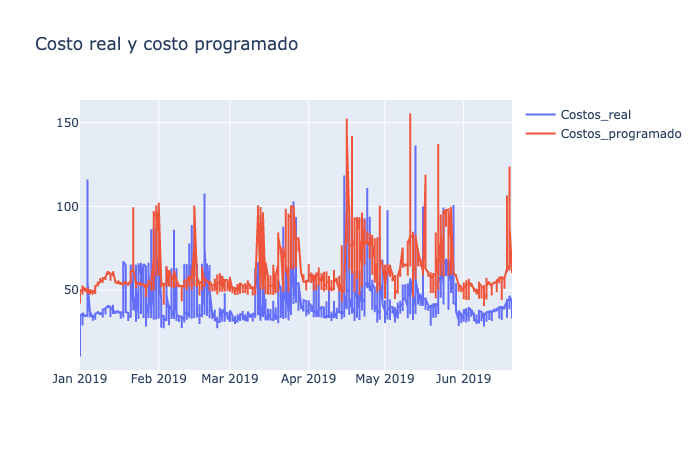

,hora,costo_real,costo_programado
count,4104.00000,4104.000000,4104.000000
mean,12.50000,43.664516,61.127861
std,6.92303,14.129571,14.297788
min,1.00000,10.386650,40.504135
25%,6.75000,35.175530,52.439992
50%,12.50000,38.219960,55.977760
75%,18.25000,46.022250,63.586729
max,24.00000,136.290680,155.448133


In [37]:
time = time_plot_costo_barra('BA01T002SE002T002','2019-01-01','2019-06-20',mostrar_grafica_dinamica=False)
time.describe()

<div class="alert alert-success" role="alert">
    <h2>Análisis</h2>
     <p align="right"/>
    Qué puedes concluir de estos plots?
   El costo programado tiende a estar por encima de los costos reales, esto podría no ser tan bueno si se piensa que se podrían ahorrar recursos si se pudieran predecir los costos
</div>

## 4. Base para los modelos

Intrucciones:

Carga la base base_para_predicción.csv. Esta será la base principal para las siguientes preguntas.

En rasgos generales, ¿Qué puedes decir de los datos? (dimensiones, tipo de datos, variables categóricas, variables numéricas, fechas).

In [7]:
_base_prediccion_df.describe()

,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
count,112779.000000,0.0,0.0,34184.000000,41818.000000,61863.000000,112779.000000,112779.000000,112779.000000,112779.00,112779.000000,1.127790e+05,112779.000000
mean,12.502993,NaN,NaN,38.120053,3.764987,40.583146,61.170058,62.215400,-1.045338,inf,2.331844,6.357056e+07,128.719565
std,6.924090,NaN,NaN,69.838109,12.904388,101.083396,25.414147,25.307759,24.711575,NaN,1.304096,3.948683e+08,167.948649
min,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-1.713131,-562.470000,-3403.97,1.000000,-9.821095e+09,2.989800
25%,7.000000,NaN,NaN,0.849787,0.000000,0.000000,49.130000,49.906745,-3.790000,-7.07,1.000000,7.464800e+05,18.420000
50%,13.000000,NaN,NaN,9.600000,0.000000,0.000000,54.610000,55.420601,-0.310000,-0.58,2.000000,4.507282e+06,51.850000
75%,19.000000,NaN,NaN,40.000000,1.571022,15.960000,63.500000,64.701951,1.670000,2.92,3.000000,1.332345e+07,184.685500
max,25.000000,NaN,NaN,472.000000,86.050000,570.600800,240.360000,610.600000,175.020000,inf,6.000000,1.004240e+10,597.782800


In [ ]:
_base_prediccion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112779 entries, 0 to 112778
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   nemotecnico_se            112779 non-null  object 
 1   fecha                     112779 non-null  object 
 2   hora                      112779 non-null  int64  
 3   gen_eolica_total_mwh      0 non-null       float64
 4   gen_geotermica_total_mwh  0 non-null       float64
 5   gen_hidraulica_total_mwh  34184 non-null   float64
 6   gen_solar_total_mwh       41818 non-null   float64
 7   gen_termica_total_mwh     61863 non-null   float64
 8   cmg_real                  112779 non-null  float64
 9   cmg_prog                  112779 non-null  float64
 10  cmg_desv                  112779 non-null  float64
 11  cmg_desv_pct              112779 non-null  float64
 12  n_barras                  112779 non-null  int64  
 13  demanda_mwh               112779 non-null  i

<div class="alert alert-block alert-warning">
 <p align="right"/>
    A partir de la variable fecha, crea nuevas variables para el año, mes, semana del año, dia del calendario, dia de la semana y una variable que indique si el dia corresponde a un día de semana o fin de semana. Estas features/variables te servirán para entrenar el modelo.
</div> 


In [8]:
#Limpiar la cadena de fecha y quitar el string 'UTC' para poder transformar la fecha en un formato predeterminado
_base_prediccion_df.fecha = [fecha.replace(' UTC','') for fecha in _base_prediccion_df.fecha.to_list()]
_base_prediccion_df.fecha = pd.to_datetime(_base_prediccion_df.fecha,format='%Y-%m-%d %H:%M:%S')
_base_prediccion_df


,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04,1,NaN,NaN,NaN,NaN,0.000,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04,2,NaN,NaN,NaN,NaN,0.000,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04,3,NaN,NaN,NaN,NaN,0.000,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04,4,NaN,NaN,NaN,NaN,0.000,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04,5,NaN,NaN,NaN,NaN,0.000,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112774,SE170T005,2019-06-30,20,NaN,NaN,NaN,NaN,0.775,44.1,41.362200,2.74,6.62,3,9334786,30.14000
112775,SE170T005,2019-06-30,21,NaN,NaN,NaN,NaN,0.925,44.1,42.217780,1.88,4.45,3,9353773,30.14000
112776,SE170T005,2019-06-30,22,NaN,NaN,NaN,NaN,0.975,44.1,42.197451,1.90,4.50,3,9114529,30.14000
112777,SE170T005,2019-06-30,23,NaN,NaN,NaN,NaN,0.750,44.1,41.473556,2.63,6.34,3,8118728,30.14000


In [9]:
#Crear features
_base_prediccion_df['año'] = _base_prediccion_df.fecha.dt.year
_base_prediccion_df['mes'] = _base_prediccion_df.fecha.dt.month
_base_prediccion_df['dia'] =_base_prediccion_df.fecha.dt.day
_base_prediccion_df['semana'] = _base_prediccion_df.fecha.dt.weekofyear
_base_prediccion_df['dia_semana'] = _base_prediccion_df.fecha.dt.dayofweek

_base_prediccion_df['finde_semana'] = [1 if dia>=5 else 0 for dia in  _base_prediccion_df.dia_semana.to_list()]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [10]:
_base_prediccion_df

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,dia,semana,dia_semana,finde_semana
0,SE031G216,2019-01-04,1,NaN,NaN,NaN,NaN,0.000,56.2,55.627852,0.57,1.02,2,1210767,13.20785,2019,1,4,1,4,0
1,SE031G216,2019-01-04,2,NaN,NaN,NaN,NaN,0.000,56.2,55.376645,0.82,1.48,2,113232,13.20785,2019,1,4,1,4,0
2,SE031G216,2019-01-04,3,NaN,NaN,NaN,NaN,0.000,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785,2019,1,4,1,4,0
3,SE031G216,2019-01-04,4,NaN,NaN,NaN,NaN,0.000,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785,2019,1,4,1,4,0
4,SE031G216,2019-01-04,5,NaN,NaN,NaN,NaN,0.000,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785,2019,1,4,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112774,SE170T005,2019-06-30,20,NaN,NaN,NaN,NaN,0.775,44.1,41.362200,2.74,6.62,3,9334786,30.14000,2019,6,30,26,6,1
112775,SE170T005,2019-06-30,21,NaN,NaN,NaN,NaN,0.925,44.1,42.217780,1.88,4.45,3,9353773,30.14000,2019,6,30,26,6,1
112776,SE170T005,2019-06-30,22,NaN,NaN,NaN,NaN,0.975,44.1,42.197451,1.90,4.50,3,9114529,30.14000,2019,6,30,26,6,1
112777,SE170T005,2019-06-30,23,NaN,NaN,NaN,NaN,0.750,44.1,41.473556,2.63,6.34,3,8118728,30.14000,2019,6,30,26,6,1


<div class="alert alert-block alert-warning">
 <p align="right"/>
    Implementa una función que para una subestación y una variable, grafique múltiples series de tiempo diarias correspondientes a una lista de fechas. Para esto, la función debe recibir como argumentos: código de una subestación, una variable (serie numérica), y una lista de fechas (año-mes-día). Por ejemplo: para la subestación SE005T002 y la variable gen_solar_total_mwh, la función debe graficar los perfiles diarios de generación solar por hora para las fechas '2019-01-10', '2019-02-10' y '2019-03-10'.
</div> 


In [ ]:
def grafica_series(subestacion,variable,periodos,mostrar_grafica_dinamica=False):
    """"""
    fig = go.Figure()
    for periodo in periodos:
        aux = _base_prediccion_df.loc[
            (_base_prediccion_df.nemotecnico_se == subestacion) &
            (_base_prediccion_df.fecha == periodo),
            ['hora',variable]
        ].sort_values(by='hora')
        fig.add_trace(
            go.Scatter(
                x=aux.hora,y=aux[variable],mode='lines',name=periodo
            )
        )
    title = f"Subestación: <b>{subestacion}</b> <br>Variable: <b>{variable}</b> <br>Periodos: <b>{', '.join(periodos)}</b>"
    fig.update_layout(title = title)
    if mostrar_grafica_dinamica: fig.show()
    fig.show("png")

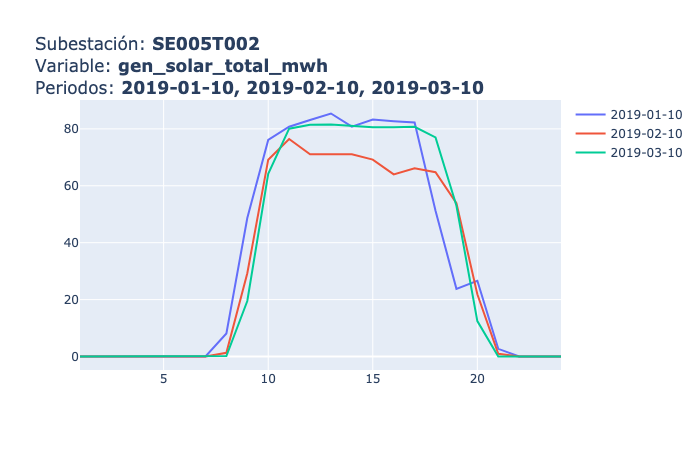

In [ ]:
grafica_series('SE005T002','gen_solar_total_mwh',['2019-01-10','2019-02-10','2019-03-10'])

<div class="alert alert-success" role="alert">
    <h2>Análisis</h2>
     <p align="right"/>
    <ul>
<li>Grafica la curva de generación solar, por hora, en la subestación SE005T002 para las fechas del 10, 11, 12, 13 y 14 de enero de 2019. Haz lo mismo para la subestación SE127T005. Que podrías decir, en términos generales, sobre la generación solar y las dos subestaciones mencionadas, basados en estos dos gráficos?</li>

Las primeras horas la subestaciones SE005T002 y SE127T005 no generan energía, esto podría deberse a que a esas horas no hay luz solar, la estación SE005T002 se mantiene mas o menos constante en el periodo definido, los días en que se ven mas fluctuaciones serían el jueves y el sabado, ya que la curva esta mas deformada.
        <br/>

<li>Para la estación SE127T005 se puede observar que las curvas son desiguales, coinciden las dos estaciones en los momentos que generan menos energía, que sería antes de las 7am y despúes de las 10pm, la estación SE127T005 tiene al día sábado como el mas fluctuante con una cresta alrededor de las 12pm y un valle pronunciado alrededor de la 1pm.</li>

Ambas subestaciones pueden tener esos comportamientos diferentes porque se encuentran en lugares muy diferentes, primero, al observar la escala del eje Y se puede ver que la generación de energía de la primera subestacion es bastante mas grande. La primera subestación puede estar cerca de un lugar en donde se requiera una cantidad de energia constante en ciertos horarios como una ciudad, en donde el tiempo en que duran los negocios abiertos podría ser cuando hay mas demanda de energía o cerca de fabricas que operan en un horario laboral normal. La segunda subestación podría ubicarse en un lugar en donde la demanda de energía sea mas pequeña, como en una localidad mas rural, en donde la demanda no tiene que ser necesariamente constante.
    </ul>
</div>



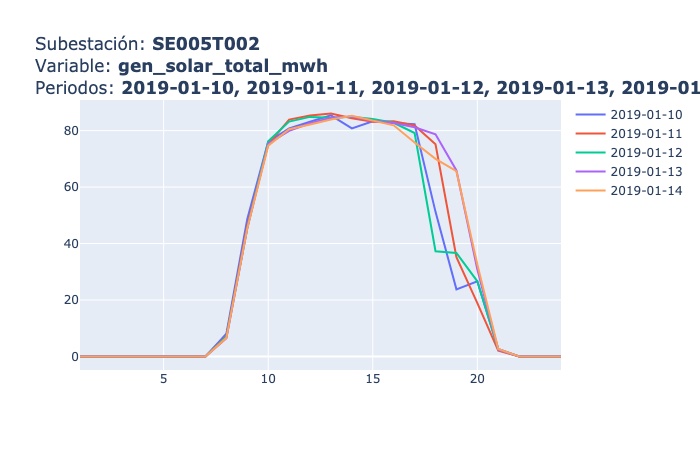

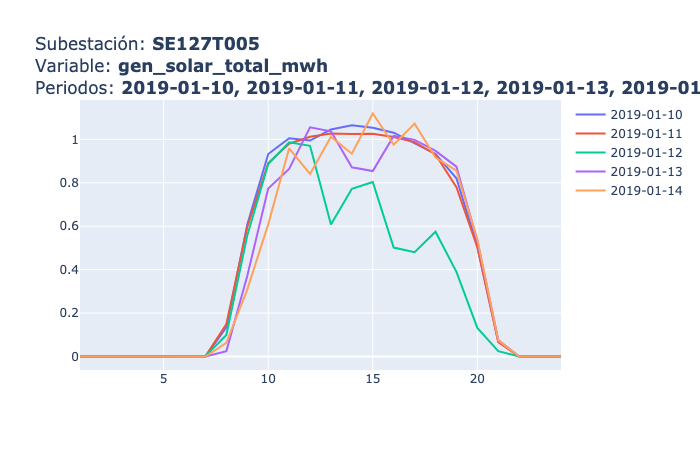

In [ ]:
###
# Generación solar Ejercicio 4 punto 4
###
grafica_series('SE005T002','gen_solar_total_mwh',['2019-01-10','2019-01-11','2019-01-12','2019-01-13','2019-01-14'])
grafica_series('SE127T005','gen_solar_total_mwh',['2019-01-10','2019-01-11','2019-01-12','2019-01-13','2019-01-14'])

<div class="alert alert-success" role="alert">
    <h2>Análisis</h2>
     <p align="right"/>
    <ul>
<li>Grafica la curva de generación térmica, por hora, en la subestación SE020G213 para los días 14, 15, 16 y 17 de mayo de 2019. Haz lo mismo para la subestación SE106G216. Que podrías decir, en términos generales, sobre la generación térmica en esta subestación con respecto a este gráfico?</li>

Este análisis ocurre durante el mes de mayo, que es donde comienzan a haber temperaturas mas frias en Chile, por lo que el consumo constante de energía térmica puede deberse a eso, se pueden observar en ambas gráficas unos valles bastante pronunciados durante el día sábado durante las 10am y pasadas las 3pm.

Asimismo, puede observarse que hay valles durante varios días de la semana después de las 3 de la tarde.
    </ul>
</div>





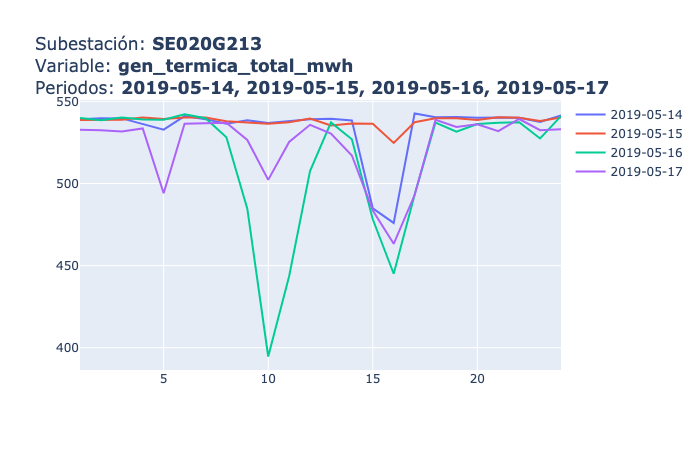

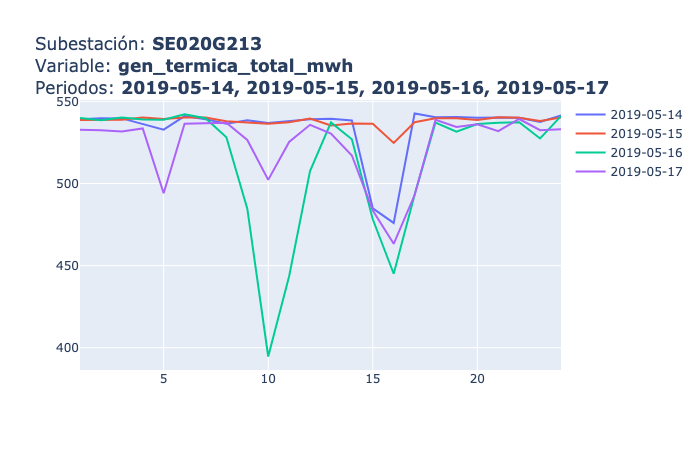

In [ ]:
#Ejercicio 4 punto 5
###
# Generación térmica
###
grafica_series('SE020G213','gen_termica_total_mwh',['2019-05-14','2019-05-15','2019-05-16','2019-05-17'])
grafica_series('SE020G213','gen_termica_total_mwh',['2019-05-14','2019-05-15','2019-05-16','2019-05-17'])

##  5. Predicción de desviaciones del costo marginal: modelo 1


In [11]:
#Quitar valores nan, armar la variable target y ordenar la tabla por fecha,hora y subestacion
_base_prediccion_df['target'] = [0 if pct >= -15 and pct<=15 else 1 for pct in _base_prediccion_df.cmg_desv_pct.to_list()]

_base_prediccion_df['gen_eolica_total_mwh'] = _base_prediccion_df['gen_eolica_total_mwh'].fillna(0)
_base_prediccion_df['gen_geotermica_total_mwh'] = _base_prediccion_df['gen_geotermica_total_mwh'].fillna(0)
_base_prediccion_df['gen_hidraulica_total_mwh'] = _base_prediccion_df['gen_hidraulica_total_mwh'].fillna(0)
_base_prediccion_df['gen_solar_total_mwh'] = _base_prediccion_df['gen_solar_total_mwh'].fillna(0)
_base_prediccion_df['gen_termica_total_mwh'] = _base_prediccion_df['gen_termica_total_mwh'].fillna(0)
_base_prediccion_df['cmg_desv_pct'] = _base_prediccion_df['cmg_desv_pct'].fillna(0)
_base_prediccion_df.loc[_base_prediccion_df.cmg_desv_pct == np.inf,['cmg_desv_pct']]=0

_base_prediccion_df['en_total_mwh']=\
                                _base_prediccion_df.gen_eolica_total_mwh +\
                                _base_prediccion_df.gen_geotermica_total_mwh +\
                                _base_prediccion_df.gen_hidraulica_total_mwh +\
                                _base_prediccion_df.gen_solar_total_mwh +\
                                _base_prediccion_df.gen_termica_total_mwh

_base_prediccion_df = _base_prediccion_df.sort_values(by = ['nemotecnico_se','fecha','hora'])
_base_prediccion_clima = _base_prediccion_df.sort_values(by = ['nemotecnico_se','fecha','hora'])
_base_prediccion_df = _base_prediccion_df.set_index('fecha')

_base_prediccion_df


,nemotecnico_se,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,dia,semana,dia_semana,finde_semana,target,en_total_mwh
fecha,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,SE001T002,1,0.0,0.0,0.0,0.0,0.000,54.03,124.604410,-70.57,-56.64,2,61148556,14.2881,2019,1,1,1,1,0,1,0.000
2019-01-01,SE001T002,2,0.0,0.0,0.0,0.0,0.000,54.03,125.415516,-71.39,-56.92,2,136880002,14.2881,2019,1,1,1,1,0,1,0.000
2019-01-01,SE001T002,3,0.0,0.0,0.0,0.0,0.000,54.03,52.383209,1.65,3.15,2,127833826,14.2881,2019,1,1,1,1,0,0,0.000
2019-01-01,SE001T002,4,0.0,0.0,0.0,0.0,0.000,54.03,53.482023,0.55,1.03,2,133924965,14.2881,2019,1,1,1,1,0,0,0.000
2019-01-01,SE001T002,5,0.0,0.0,0.0,0.0,0.000,54.03,52.260469,1.77,3.39,2,138980453,14.2881,2019,1,1,1,1,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,SE170T005,20,0.0,0.0,0.0,0.0,0.775,44.10,41.362200,2.74,6.62,3,9334786,30.1400,2019,6,30,26,6,1,0,0.775
2019-06-30,SE170T005,21,0.0,0.0,0.0,0.0,0.925,44.10,42.217780,1.88,4.45,3,9353773,30.1400,2019,6,30,26,6,1,0,0.925
2019-06-30,SE170T005,22,0.0,0.0,0.0,0.0,0.975,44.10,42.197451,1.90,4.50,3,9114529,30.1400,2019,6,30,26,6,1,0,0.975


In [12]:
#Observar el balanceo de los datos
_base_prediccion_df.groupby(['nemotecnico_se'])['nemotecnico_se'].count().reset_index(name='Contadores_Unicos')

,nemotecnico_se,Contadores_Unicos
0,SE001T002,4345
1,SE003T011,4345
2,SE004L079,4345
3,SE004T002,4345
4,SE005R002,4345
5,SE005T002,4345
6,SE005T003,4345
7,SE008G010,4345
8,SE009G004,4345
9,SE009T002,4345


In [13]:
_base_prediccion_df.groupby(['target'])['target'].count().reset_index(name='Contadores_Unicos')

,target,Contadores_Unicos
0,0,84288
1,1,28491


In [14]:
#Se van a eliminar dos columnas que solo contienen ceros y estos no aportan mas informacion al modelo
_base_prediccion_drop_cero = _base_prediccion_df.drop(labels=['gen_eolica_total_mwh','gen_geotermica_total_mwh'],axis=1)
_base_prediccion_clima =  _base_prediccion_df.drop(labels=['gen_eolica_total_mwh','gen_geotermica_total_mwh'],axis=1)

_base_prediccion_drop_cero

,nemotecnico_se,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,dia,semana,dia_semana,finde_semana,target,en_total_mwh
fecha,,,,,,,,,,,,,,,,,,,,
2019-01-01,SE001T002,1,0.0,0.0,0.000,54.03,124.604410,-70.57,-56.64,2,61148556,14.2881,2019,1,1,1,1,0,1,0.000
2019-01-01,SE001T002,2,0.0,0.0,0.000,54.03,125.415516,-71.39,-56.92,2,136880002,14.2881,2019,1,1,1,1,0,1,0.000
2019-01-01,SE001T002,3,0.0,0.0,0.000,54.03,52.383209,1.65,3.15,2,127833826,14.2881,2019,1,1,1,1,0,0,0.000
2019-01-01,SE001T002,4,0.0,0.0,0.000,54.03,53.482023,0.55,1.03,2,133924965,14.2881,2019,1,1,1,1,0,0,0.000
2019-01-01,SE001T002,5,0.0,0.0,0.000,54.03,52.260469,1.77,3.39,2,138980453,14.2881,2019,1,1,1,1,0,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,SE170T005,20,0.0,0.0,0.775,44.10,41.362200,2.74,6.62,3,9334786,30.1400,2019,6,30,26,6,1,0,0.775
2019-06-30,SE170T005,21,0.0,0.0,0.925,44.10,42.217780,1.88,4.45,3,9353773,30.1400,2019,6,30,26,6,1,0,0.925
2019-06-30,SE170T005,22,0.0,0.0,0.975,44.10,42.197451,1.90,4.50,3,9114529,30.1400,2019,6,30,26,6,1,0,0.975


In [15]:
#Hacer variables dummy
_base_prediccion_dummies = pd.get_dummies(_base_prediccion_drop_cero, columns=['nemotecnico_se','hora','mes','semana','dia_semana'])

print(_base_prediccion_dummies.shape)
_base_prediccion_dummies

(112779, 108)


,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,dia,finde_semana,target,en_total_mwh,nemotecnico_se_SE001T002,nemotecnico_se_SE003T011,nemotecnico_se_SE004L079,nemotecnico_se_SE004T002,nemotecnico_se_SE005R002,nemotecnico_se_SE005T002,nemotecnico_se_SE005T003,nemotecnico_se_SE008G010,nemotecnico_se_SE009G004,nemotecnico_se_SE009T002,nemotecnico_se_SE014T002,nemotecnico_se_SE015R002,nemotecnico_se_SE019T002,nemotecnico_se_SE020G213,nemotecnico_se_SE028T002,nemotecnico_se_SE031G216,nemotecnico_se_SE036T002,nemotecnico_se_SE039R002,nemotecnico_se_SE055T002,nemotecnico_se_SE055T005,nemotecnico_se_SE067T005,nemotecnico_se_SE071T005,nemotecnico_se_SE081T005,nemotecnico_se_SE082T005,nemotecnico_se_SE103L123,...,hora_25,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,semana_1,semana_2,semana_3,semana_4,semana_5,semana_6,semana_7,semana_8,semana_9,semana_10,semana_11,semana_12,semana_13,semana_14,semana_15,semana_16,semana_17,semana_18,semana_19,semana_20,semana_21,semana_22,semana_23,semana_24,semana_25,semana_26,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.0,0.0,0.000,54.03,124.604410,-70.57,-56.64,2,61148556,14.2881,2019,1,0,1,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,125.415516,-71.39,-56.92,2,136880002,14.2881,2019,1,0,1,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,52.383209,1.65,3.15,2,127833826,14.2881,2019,1,0,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,53.482023,0.55,1.03,2,133924965,14.2881,2019,1,0,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,52.260469,1.77,3.39,2,138980453,14.2881,2019,1,0,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,0.0,0.0,0.775,44.10,41.362200,2.74,6.62,3,9334786,30.1400,2019,30,1,0,0.775,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2019-06-30,0.0,0.0,0.925,44.10,42.217780,1.88,4.45,3,9353773,30.1400,2019,30,1,0,0.925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2019-06-30,0.0,0.0,0.975,44.10,42.197451,1.90,4.50,3,9114529,30.1400,2019,30,1,0,0.975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


<div class="alert alert-block alert-warning">
    <h3>Modelo con MLP </h3>
 <p align="right"/>
    Este es un modelo que a través de un regresor se busca aproximar al valor cero o uno, las variables dummy se contruyeron a partir de las variables discretas, y van a ayudarle a la red a entender todas las entradas bajo el mismo contexto y que pueda resultarle mas facil entender las relaciones.Las variables continuas tendrán que ser normalizadas a valores entre cero y uno, para que estén también en el mismo contexto que la variable objetivo.
</div>



In [16]:
keras.backend.clear_session()
###
# Seeds
###
np.random.seed(1)
tf.random.set_seed(1)

In [18]:
###
# Preparacion de los datos
###
#Selección de columnas que no se utilizarán
data_for_model = _base_prediccion_df.drop(labels=['año','dia'],axis=1)
data_for_model
#Dummies
data_for_model = pd.get_dummies(data_for_model,columns=['nemotecnico_se','hora','mes','semana','dia_semana'])
#Normalización
values_for_train_model = data_for_model.drop(labels='target',axis=1).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values_for_train_model)
yhat = data_for_model.target.values
print(f'Tamaño de los datos normalizados: {scaled.shape}, tamaño de la yhat normalizada: {yhat.shape}')
#Sepatación de conjuntos de train y testing (no hacemos suffle de los datos)
X_train, Y_train, X_test,Y_test = scaled[:90224,:],yhat[:90224],scaled[90224:,],yhat[90224:]
#Redifiniendo las domensiones para machear con tensorflow
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))
X_test  = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

Tamaño de los datos normalizados: (112779, 107), tamaño de la yhat normalizada: (112779,)


In [19]:
###
# Creación de módelo
#Se usará un modelo secuencial de keras con una capa completamente conectada a la entrada y un vector flatten que reducirá las caracteristicas
#Una capa con una neurona a la salida que será la que intentará pronosticar un valor cercano al cero o uno
#Además de la función tanh que es la que mejor desempeño ha tenido para aporximaciones
###
def modelo_red():
    """"""
    model = Sequential()
    model.add(Dense(28, input_shape=(1,107),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [20]:
###
# Entrenamiento del módelo
###
EPOCHS=40
batch_size=4

model = modelo_red()

history=model.fit(
    X_train,
    Y_train,
    epochs=EPOCHS,
    validation_split=0.2,
    batch_size=4,
    verbose=1,
    shuffle=False
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 28)             3024      
_________________________________________________________________
flatten (Flatten)            (None, 28)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 29        
Total params: 3,053
Trainable params: 3,053
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
18045/18045 [==============================] - 46s 3ms/step - loss: 0.2530 - mse: 0.2099 - val_loss: 0.2719 - val_mse: 0.2655
Epoch 2/40
18045/18045 [==============================] - 45s 3ms/step - loss: 0.2432 - mse: 0.1987 - val_loss: 0.2827 - val_mse: 0.2703
Epoch 3/40
18045/18045 [==============================] - 44s 2ms/step - loss: 0.2419 - mse: 0.1822 - val_loss

In [21]:
import matplotlib.pylab as plt
%matplotlib inline

In [23]:
###
# Visualizando resultados
###
results=model.predict(X_test)

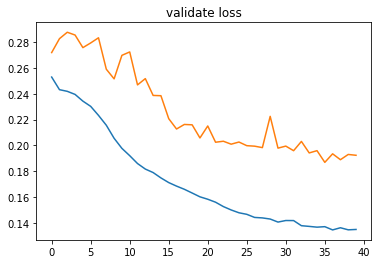

In [24]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

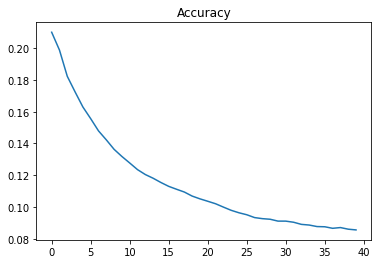

In [25]:
plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.show()

In [28]:
#Se van a comparar los resultados que obtuvo la red a través de un umbral, 
#esta red será capaz de pronosticar si habra un ajuste en los costos marginales a futuro
#Se va a comparar la Y_test que serían los valores correctos, contra los resultados de las predicciones
compara = pd.DataFrame(np.array([Y_test, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

#inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(compara)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']

compara2['prediccion'] = compara2.prediccion.round()
compara2['coincidencia'] = ['Aciertos' if x==y else 'No_Aciertos' for x,y in zip(compara2.real.to_list(),compara2.prediccion.to_list())]

compara2.head(30)

,real,prediccion,diferencia,coincidencia
0,0.0,-0.0,0.089879,Aciertos
1,0.0,-0.0,0.087546,Aciertos
2,1.0,-0.0,1.084156,No_Aciertos
3,1.0,-0.0,1.089718,No_Aciertos
4,1.0,-0.0,1.091191,No_Aciertos
5,1.0,-0.0,1.081568,No_Aciertos
6,1.0,-0.0,1.094940,No_Aciertos
7,1.0,-0.0,1.093014,No_Aciertos
8,1.0,-0.0,1.097140,No_Aciertos
9,1.0,1.0,0.347892,Aciertos


In [29]:
#Se enumeran las coincidencias de aciertos y errores de la red
compara2.groupby(['coincidencia'])['coincidencia'].count().reset_index(name='Contadores')

,coincidencia,Contadores
0,Aciertos,18520
1,No_Aciertos,4035


Procentaje de exactitud: 88.09576590556418


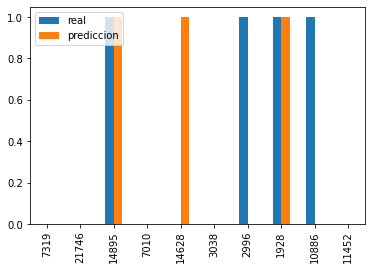

In [31]:
#Se ve graficamente como esta funcionando el modelo,
#Cuando no aparece ninguna barra ni en real ni en prediccion quiere decir que el modelo 
#Acertó a cero, cuando hay dos barras juntas de real y prediccion quiere decir que 
#la red acertó a valor uno, solo hay desaciertos si hay una barra sola, porque quiere
#decir que la red predijo lo contrario al valor real
compara2[['real','prediccion']].sample(n=10).plot(kind='bar')
print(f'Procentaje de exactitud: {(19870*100)/(19870+2685)}')

In [34]:
#Se guardan los pesos
model.save('/content/drive/My Drive/MLP_Aproximacion.h5')
json_config = model.to_json()
with open('/content/drive/My Drive/MLP_Aproximacion.json', 'w') as json_file:
    json_file.write(json_config)

<div class="alert alert-block alert-warning">
    <h3>6. Modelo con embeddings para pronosticar </h3>
 <p align="right"/>
    Para este enfoque se cambio el modelo a una red LSTM y la variable target ahora pasó a ser 'cmg_desv_pct' por lo que esta nueva red intentará aproximarse a ese valor a través de una serie de tiempo
</div>



In [35]:

#Borrar atributos menos relevantes y que pudieran causar ruido en la red

_base_prediccion_prep = _base_prediccion_dummies.drop(labels=['dia','año','cmg_desv','demanda_mwh','cap_inst_mw','n_barras','target'],axis=1)
_base_prediccion_prep

,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv_pct,finde_semana,en_total_mwh,nemotecnico_se_SE001T002,nemotecnico_se_SE003T011,nemotecnico_se_SE004L079,nemotecnico_se_SE004T002,nemotecnico_se_SE005R002,nemotecnico_se_SE005T002,nemotecnico_se_SE005T003,nemotecnico_se_SE008G010,nemotecnico_se_SE009G004,nemotecnico_se_SE009T002,nemotecnico_se_SE014T002,nemotecnico_se_SE015R002,nemotecnico_se_SE019T002,nemotecnico_se_SE020G213,nemotecnico_se_SE028T002,nemotecnico_se_SE031G216,nemotecnico_se_SE036T002,nemotecnico_se_SE039R002,nemotecnico_se_SE055T002,nemotecnico_se_SE055T005,nemotecnico_se_SE067T005,nemotecnico_se_SE071T005,nemotecnico_se_SE081T005,nemotecnico_se_SE082T005,nemotecnico_se_SE103L123,nemotecnico_se_SE106G216,nemotecnico_se_SE123G216,nemotecnico_se_SE127T005,nemotecnico_se_SE170T005,hora_1,hora_2,hora_3,...,hora_25,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,semana_1,semana_2,semana_3,semana_4,semana_5,semana_6,semana_7,semana_8,semana_9,semana_10,semana_11,semana_12,semana_13,semana_14,semana_15,semana_16,semana_17,semana_18,semana_19,semana_20,semana_21,semana_22,semana_23,semana_24,semana_25,semana_26,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.0,0.0,0.000,54.03,124.604410,-56.64,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,125.415516,-56.92,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,52.383209,3.15,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,53.482023,1.03,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,52.260469,3.39,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,0.0,0.0,0.775,44.10,41.362200,6.62,1,0.775,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2019-06-30,0.0,0.0,0.925,44.10,42.217780,4.45,1,0.925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2019-06-30,0.0,0.0,0.975,44.10,42.197451,4.50,1,0.975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


<div class="alert alert-block alert-warning">
    <h4>Normalizar </h4>
 <p align="right"/>
    Ya que esto es una serie que depende del tiempo, se debe realizar un desface para lograr un aprendizaje supervisado, como el dataset tiene a la hora como un factor importante en la medida de los peridos, entonces al hacer un paso de 2 el algoritmo hará un desplazamiento de 2 filas 'hacia el futuro' así la red tendrá un valor cercano del que pueda tener una especie de referencia para predecir.
</div>



In [36]:
PASOS=2
# Convertir la serie a un aprendizaje supervisado a través del desface
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # secuencia (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('cmg_desv%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('cmg_desv%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('cmg_desv%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    df_concat = pd.concat(cols, axis=1)
    df_concar.columns = names
    if dropnan:##Borrar nan de las filas superiores que desplazo
        df_concat.dropna(inplace=True)
    return df_concat

In [37]:
#Normalizamos los datos Xs a entrenar
scaler = MinMaxScaler(feature_range=(0, 1))
x_data = _base_prediccion_prep.drop(labels = 'cmg_desv_pct',axis=1)
scaled = scaler.fit_transform(x_data)
scaled = scaled[1:-1,:]
#Creamos los pasos  de la variable objetivo
y_data = _base_prediccion_prep.cmg_desv_pct.values
y_data=y_data.reshape(-1, 1)
y_scaled = scaler.fit_transform(y_data)
y_pasos = series_to_supervised(y_scaled,PASOS, 1, dropnan=True).values

print(scaled.shape,y_pasos.shape)
x_total = np.concatenate([scaled,y_pasos],axis=1)
print(x_total.shape)

(112777, 100) (112777, 3)
(112777, 103)


In [38]:
_base_prediccion_prep

,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv_pct,finde_semana,en_total_mwh,nemotecnico_se_SE001T002,nemotecnico_se_SE003T011,nemotecnico_se_SE004L079,nemotecnico_se_SE004T002,nemotecnico_se_SE005R002,nemotecnico_se_SE005T002,nemotecnico_se_SE005T003,nemotecnico_se_SE008G010,nemotecnico_se_SE009G004,nemotecnico_se_SE009T002,nemotecnico_se_SE014T002,nemotecnico_se_SE015R002,nemotecnico_se_SE019T002,nemotecnico_se_SE020G213,nemotecnico_se_SE028T002,nemotecnico_se_SE031G216,nemotecnico_se_SE036T002,nemotecnico_se_SE039R002,nemotecnico_se_SE055T002,nemotecnico_se_SE055T005,nemotecnico_se_SE067T005,nemotecnico_se_SE071T005,nemotecnico_se_SE081T005,nemotecnico_se_SE082T005,nemotecnico_se_SE103L123,nemotecnico_se_SE106G216,nemotecnico_se_SE123G216,nemotecnico_se_SE127T005,nemotecnico_se_SE170T005,hora_1,hora_2,hora_3,...,hora_25,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,semana_1,semana_2,semana_3,semana_4,semana_5,semana_6,semana_7,semana_8,semana_9,semana_10,semana_11,semana_12,semana_13,semana_14,semana_15,semana_16,semana_17,semana_18,semana_19,semana_20,semana_21,semana_22,semana_23,semana_24,semana_25,semana_26,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.0,0.0,0.000,54.03,124.604410,-56.64,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,125.415516,-56.92,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,52.383209,3.15,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,53.482023,1.03,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,52.260469,3.39,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,0.0,0.0,0.775,44.10,41.362200,6.62,1,0.775,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2019-06-30,0.0,0.0,0.925,44.10,42.217780,4.45,1,0.925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2019-06-30,0.0,0.0,0.975,44.10,42.197451,4.50,1,0.975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [39]:
#training_data.head()
x_test = scaled[90222:112777]
y_test = y_data[90222:112777]

x_train = scaled[0:90222]
y_train = y_data[0:90222]

x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
x_test  = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
#training_data.head()
print(type(x_test))

(90222, 1, 100) (90222, 1) (22555, 1, 100) (22555, 1)
<class 'numpy.ndarray'>


In [40]:
def modeloEmbeddings():
    model = Sequential()
    model.add(LSTM(50, activation='tanh', input_shape=(1,100)))
    model.add(Dense(25, activation='tanh', input_shape=(1,50)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error',metrics = ['MSE'])
    model.summary()
    return model

In [41]:
np.random.seed(1)
tf.random.set_seed(1)

model = modeloEmbeddings()
history = model.fit(x_train, y_train, epochs=40, validation_split=0.2, verbose=1,batch_size=4,shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                30200     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 31,501
Trainable params: 31,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
18045/18045 [==============================] - 63s 3ms/step - loss: 95.1710 - MSE: 5467173.0000 - val_loss: 113.9398 - val_MSE: 9688613.0000
Epoch 2/40
18045/18045 [==============================] - 61s 3ms/step - loss: 93.5879 - MSE: 5466884.0000 - val_loss: 112.8875 - val_MSE: 9687950.0000
Epoch 3/40
18045/18045 [==============================] - 61s 3ms/step - los

In [66]:
#Desnormalizar la y_predict
y_results=model.predict(x_test)
inverted = scaler.inverse_transform(y_results)

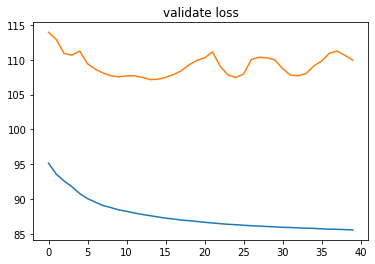

In [67]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()
#Se puede observar que el error se estancó

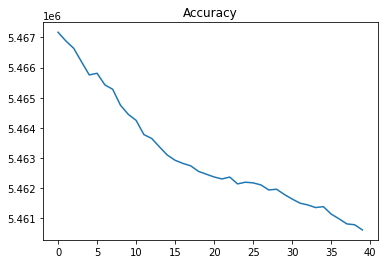

In [68]:
plt.title('Accuracy')
plt.plot(history.history['MSE'])
plt.show()

In [69]:
compara_lstm = pd.DataFrame(np.array([y_test.reshape(22555), [x[0] for x in inverted.reshape(22555,1)]])).transpose()
compara_lstm.columns = ['real', 'prediccion']

#inverted = scaler.inverse_transform(compara.values)

compara2_lstm = pd.DataFrame(compara_lstm)
compara2_lstm.columns = ['real', 'prediccion']
compara2_lstm['diferencia'] = compara2_lstm['real'] - compara2_lstm['prediccion']

In [52]:
#Salvar pesos
model.save('/content/drive/My Drive/LSTM_prediccion.h5')
json_config = model.to_json()
with open('/content/drive/My Drive/LSTM_prediccion.json', 'w') as json_file:
    json_file.write(json_config)

In [ ]:
del model
keras.backend.clear_session()

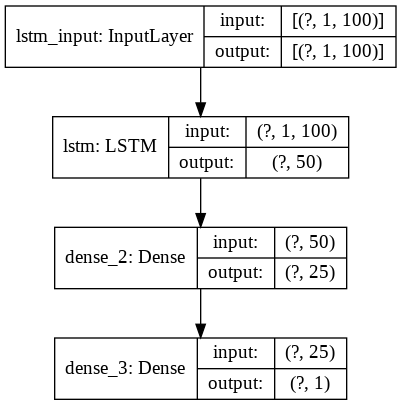

In [53]:
#Conexión del modelo
keras.utils.plot_model(model,"model.png",show_shapes = True)

## 7. Merge con datos de clima: modelo 3

Instrucciones:

Haz un merge con los datos de clima (datos_clima.csv) y entrena nuevamente tu modelo 2.

In [54]:
_datos_clima_df

,fecha,subestacion,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,2019-05-06 00:00:00 UTC,SE019T002,-28.470641,-71.252694,2.00,0.31,0.00,74.66,16.39,11.94,19.01,13.93,1.78,16.62,4.14,4.93,2.81,5.01,6.23,3.50
1,2019-05-21 00:00:00 UTC,SE005T003,-42.626987,-73.805673,2.00,0.54,0.01,92.82,5.55,4.45,9.39,3.32,0.77,6.50,2.64,2.94,2.04,4.20,4.94,3.55
2,2019-02-28 00:00:00 UTC,SE005T003,-42.626987,-73.805673,2.00,0.21,2.35,88.87,12.25,10.45,15.64,9.61,2.34,12.44,2.62,3.77,1.78,4.16,5.68,2.85
3,2019-01-08 00:00:00 UTC,SE004T002,-39.549899,-72.912208,2.00,0.16,5.96,92.22,9.52,8.30,10.88,7.90,1.62,10.17,2.70,4.02,1.67,4.96,6.87,2.97
4,2019-05-07 00:00:00 UTC,SE003T011,-35.685919,-71.377335,2.00,0.37,0.00,44.02,13.57,1.49,20.38,9.57,1.05,11.34,1.69,3.58,0.65,2.25,4.42,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5244,2019-06-03 00:00:00 UTC,SE067T005,-34.119671,-70.753847,1.81,0.39,0.00,37.03,11.94,-2.41,20.67,6.78,0.60,7.71,1.97,3.04,0.50,2.51,3.95,0.49
5245,2019-05-30 00:00:00 UTC,SE082T005,-30.690328,-70.954981,1.81,0.34,1.23,83.22,3.02,0.45,7.44,0.31,0.96,3.38,3.46,6.87,1.71,4.35,7.19,2.61
5246,2019-05-07 00:00:00 UTC,SE008G010,-32.749506,-71.481002,1.81,0.31,0.01,60.68,14.95,7.48,21.80,10.45,1.56,15.52,2.37,3.96,0.84,2.72,4.29,0.67
5247,2019-06-09 00:00:00 UTC,SE003T011,-35.685919,-71.377335,1.81,0.42,0.00,46.51,8.77,-2.12,15.99,5.62,0.78,5.31,1.17,2.54,0.17,1.59,2.93,0.25


In [55]:
#Limpieza de la tabla de datos clima

,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv_pct,finde_semana,en_total_mwh,nemotecnico_se_SE001T002,nemotecnico_se_SE003T011,nemotecnico_se_SE004L079,nemotecnico_se_SE004T002,nemotecnico_se_SE005R002,nemotecnico_se_SE005T002,nemotecnico_se_SE005T003,nemotecnico_se_SE008G010,nemotecnico_se_SE009G004,nemotecnico_se_SE009T002,nemotecnico_se_SE014T002,nemotecnico_se_SE015R002,nemotecnico_se_SE019T002,nemotecnico_se_SE020G213,nemotecnico_se_SE028T002,nemotecnico_se_SE031G216,nemotecnico_se_SE036T002,nemotecnico_se_SE039R002,nemotecnico_se_SE055T002,nemotecnico_se_SE055T005,nemotecnico_se_SE067T005,nemotecnico_se_SE071T005,nemotecnico_se_SE081T005,nemotecnico_se_SE082T005,nemotecnico_se_SE103L123,nemotecnico_se_SE106G216,nemotecnico_se_SE123G216,nemotecnico_se_SE127T005,nemotecnico_se_SE170T005,hora_1,hora_2,hora_3,...,hora_25,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,semana_1,semana_2,semana_3,semana_4,semana_5,semana_6,semana_7,semana_8,semana_9,semana_10,semana_11,semana_12,semana_13,semana_14,semana_15,semana_16,semana_17,semana_18,semana_19,semana_20,semana_21,semana_22,semana_23,semana_24,semana_25,semana_26,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.0,0.0,0.000,54.03,124.604410,-56.64,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,125.415516,-56.92,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,52.383209,3.15,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,53.482023,1.03,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.000,54.03,52.260469,3.39,0,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,0.0,0.0,0.775,44.10,41.362200,6.62,1,0.775,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2019-06-30,0.0,0.0,0.925,44.10,42.217780,4.45,1,0.925,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2019-06-30,0.0,0.0,0.975,44.10,42.197451,4.50,1,0.975,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [56]:
#Se quita la cadena 'UTC' y se me da un formato fecha 
_datos_clima_df.fecha = [fecha.replace(' UTC','') for fecha in _datos_clima_df.fecha.to_list()]
_datos_clima_df.fecha = pd.to_datetime(_datos_clima_df.fecha,format='%Y-%m-%d %H:%M:%S')

In [57]:
#Se cambia el nombre de la columna de subestacion para que pueda usarse este valor
#para que pueda usarse como atributo para mezclar las tablas
_datos_clima_df= _datos_clima_df.rename(columns = {'subestacion':'nemotecnico_se'})

_datos_clima_df

,fecha,nemotecnico_se,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
0,2019-05-06,SE019T002,-28.470641,-71.252694,2.00,0.31,0.00,74.66,16.39,11.94,19.01,13.93,1.78,16.62,4.14,4.93,2.81,5.01,6.23,3.50
1,2019-05-21,SE005T003,-42.626987,-73.805673,2.00,0.54,0.01,92.82,5.55,4.45,9.39,3.32,0.77,6.50,2.64,2.94,2.04,4.20,4.94,3.55
2,2019-02-28,SE005T003,-42.626987,-73.805673,2.00,0.21,2.35,88.87,12.25,10.45,15.64,9.61,2.34,12.44,2.62,3.77,1.78,4.16,5.68,2.85
3,2019-01-08,SE004T002,-39.549899,-72.912208,2.00,0.16,5.96,92.22,9.52,8.30,10.88,7.90,1.62,10.17,2.70,4.02,1.67,4.96,6.87,2.97
4,2019-05-07,SE003T011,-35.685919,-71.377335,2.00,0.37,0.00,44.02,13.57,1.49,20.38,9.57,1.05,11.34,1.69,3.58,0.65,2.25,4.42,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5244,2019-06-03,SE067T005,-34.119671,-70.753847,1.81,0.39,0.00,37.03,11.94,-2.41,20.67,6.78,0.60,7.71,1.97,3.04,0.50,2.51,3.95,0.49
5245,2019-05-30,SE082T005,-30.690328,-70.954981,1.81,0.34,1.23,83.22,3.02,0.45,7.44,0.31,0.96,3.38,3.46,6.87,1.71,4.35,7.19,2.61
5246,2019-05-07,SE008G010,-32.749506,-71.481002,1.81,0.31,0.01,60.68,14.95,7.48,21.80,10.45,1.56,15.52,2.37,3.96,0.84,2.72,4.29,0.67
5247,2019-06-09,SE003T011,-35.685919,-71.377335,1.81,0.42,0.00,46.51,8.77,-2.12,15.99,5.62,0.78,5.31,1.17,2.54,0.17,1.59,2.93,0.25


In [58]:
#Mezclar las tablas de datos clima o y la base de datos de prediccion
merge_clima_pred = pd.merge(_base_prediccion_clima,_datos_clima_df,on = ['nemotecnico_se','fecha'],how = 'inner')

In [59]:
#Ordenar los datos por su fecha
merge_clima_pred.sort_values(by='fecha',inplace=True)
merge_clima_pred.set_index('fecha',inplace=True)
merge_clima_pred

,nemotecnico_se,hora,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,año,mes,dia,semana,dia_semana,finde_semana,target,en_total_mwh,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,SE001T002,1,0.0,0.0,0.0,54.030000,124.604410,-70.570,-56.640000,2,61148556,14.2881,2019,1,1,1,1,0,1,0.0,-27.487872,-70.388010,8.86,0.73,0.00,37.11,21.08,5.78,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21
2019-01-01,SE004L079,6,0.0,0.0,0.0,47.070000,42.670953,4.400,10.310000,1,0,51.8500,2019,1,1,1,1,0,0,0.0,-33.607927,-70.557676,9.77,0.80,0.00,18.92,22.76,-2.15,31.45,13.63,0.63,24.66,2.67,4.66,0.62,2.67,4.42,0.29
2019-01-01,SE004L079,5,0.0,0.0,0.0,47.370000,50.520006,-3.150,-6.240000,1,0,51.8500,2019,1,1,1,1,0,0,0.0,-33.607927,-70.557676,9.77,0.80,0.00,18.92,22.76,-2.15,31.45,13.63,0.63,24.66,2.67,4.66,0.62,2.67,4.42,0.29
2019-01-01,SE004L079,4,0.0,0.0,0.0,49.470000,50.520006,-1.050,-2.080000,1,0,51.8500,2019,1,1,1,1,0,0,0.0,-33.607927,-70.557676,9.77,0.80,0.00,18.92,22.76,-2.15,31.45,13.63,0.63,24.66,2.67,4.66,0.62,2.67,4.42,0.29
2019-01-01,SE004L079,3,0.0,0.0,0.0,50.320000,50.803378,-0.480,-0.940000,1,0,51.8500,2019,1,1,1,1,0,0,0.0,-33.607927,-70.557676,9.77,0.80,0.00,18.92,22.76,-2.15,31.45,13.63,0.63,24.66,2.67,4.66,0.62,2.67,4.42,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,SE014T002,4,0.0,0.0,0.0,37.795000,37.936034,-0.140,-0.370000,3,71222806,83.4631,2019,6,30,26,6,1,0,0.0,-26.397377,-70.038307,1.99,0.35,0.00,52.06,12.71,3.13,18.55,8.97,0.99,13.04,1.76,4.52,0.21,2.24,4.42,0.30
2019-06-30,SE014T002,3,0.0,0.0,0.0,38.035000,38.269629,-0.235,-0.615000,3,76980171,83.4631,2019,6,30,26,6,1,0,0.0,-26.397377,-70.038307,1.99,0.35,0.00,52.06,12.71,3.13,18.55,8.97,0.99,13.04,1.76,4.52,0.21,2.24,4.42,0.30
2019-06-30,SE014T002,2,0.0,0.0,0.0,38.035000,38.671572,-0.635,-1.645000,3,76290951,83.4631,2019,6,30,26,6,1,0,0.0,-26.397377,-70.038307,1.99,0.35,0.00,52.06,12.71,3.13,18.55,8.97,0.99,13.04,1.76,4.52,0.21,2.24,4.42,0.30


In [60]:
#Convertir las variables numéricas a variables categóricas
merge_clima_pred = pd.get_dummies(merge_clima_pred, columns=['nemotecnico_se','hora','mes','semana','dia_semana'])

print(merge_clima_pred.shape)

(112779, 126)


In [61]:
#Borrar las variables que aportan menos informacion a la red
merge_clima_pred = merge_clima_pred.drop(labels=['dia','año','cmg_desv','demanda_mwh','cap_inst_mw','n_barras','target'],axis=1)
merge_clima_pred

,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv_pct,finde_semana,en_total_mwh,lat,lon,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN,nemotecnico_se_SE001T002,nemotecnico_se_SE003T011,nemotecnico_se_SE004L079,nemotecnico_se_SE004T002,nemotecnico_se_SE005R002,nemotecnico_se_SE005T002,nemotecnico_se_SE005T003,nemotecnico_se_SE008G010,nemotecnico_se_SE009G004,nemotecnico_se_SE009T002,nemotecnico_se_SE014T002,nemotecnico_se_SE015R002,nemotecnico_se_SE019T002,nemotecnico_se_SE020G213,...,hora_25,mes_1,mes_2,mes_3,mes_4,mes_5,mes_6,semana_1,semana_2,semana_3,semana_4,semana_5,semana_6,semana_7,semana_8,semana_9,semana_10,semana_11,semana_12,semana_13,semana_14,semana_15,semana_16,semana_17,semana_18,semana_19,semana_20,semana_21,semana_22,semana_23,semana_24,semana_25,semana_26,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.0,0.0,0.0,54.030000,124.604410,-56.640000,0,0.0,-27.487872,-70.388010,8.86,0.73,0.00,37.11,21.08,5.78,27.92,15.05,1.24,25.32,3.02,6.34,0.18,2.82,5.46,0.21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.0,47.070000,42.670953,10.310000,0,0.0,-33.607927,-70.557676,9.77,0.80,0.00,18.92,22.76,-2.15,31.45,13.63,0.63,24.66,2.67,4.66,0.62,2.67,4.42,0.29,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.0,47.370000,50.520006,-6.240000,0,0.0,-33.607927,-70.557676,9.77,0.80,0.00,18.92,22.76,-2.15,31.45,13.63,0.63,24.66,2.67,4.66,0.62,2.67,4.42,0.29,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.0,49.470000,50.520006,-2.080000,0,0.0,-33.607927,-70.557676,9.77,0.80,0.00,18.92,22.76,-2.15,31.45,13.63,0.63,24.66,2.67,4.66,0.62,2.67,4.42,0.29,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2019-01-01,0.0,0.0,0.0,50.320000,50.803378,-0.940000,0,0.0,-33.607927,-70.557676,9.77,0.80,0.00,18.92,22.76,-2.15,31.45,13.63,0.63,24.66,2.67,4.66,0.62,2.67,4.42,0.29,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,0.0,0.0,0.0,37.795000,37.936034,-0.370000,1,0.0,-26.397377,-70.038307,1.99,0.35,0.00,52.06,12.71,3.13,18.55,8.97,0.99,13.04,1.76,4.52,0.21,2.24,4.42,0.30,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2019-06-30,0.0,0.0,0.0,38.035000,38.269629,-0.615000,1,0.0,-26.397377,-70.038307,1.99,0.35,0.00,52.06,12.71,3.13,18.55,8.97,0.99,13.04,1.76,4.52,0.21,2.24,4.42,0.30,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2019-06-30,0.0,0.0,0.0,38.035000,38.671572,-1.645000,1,0.0,-26.397377,-70.038307,1.99,0.35,0.00,52.06,12.71,3.13,18.55,8.97,0.99,13.04,1.76,4.52,0.21,2.24,4.42,0.30,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [62]:
#Normalizar los Xs que se van a entrenar
scaler = MinMaxScaler(feature_range=(0, 1))
x_data = merge_clima_pred.drop(labels = 'cmg_desv_pct',axis=1)
scaled = scaler.fit_transform(x_data)
scaled = scaled[1:-1,:]
#Creamos los pasos  de la variable objetivo
y_data = merge_clima_pred.cmg_desv_pct.values
y_data=y_data.reshape(-1, 1)
y_scaled = scaler.fit_transform(y_data)
y_pasos = series_to_supervised(y_scaled,PASOS, 1, dropnan=True).values

print(scaled.shape,y_pasos.shape)
x_total = np.concatenate([scaled,y_pasos],axis=1)
print(x_total.shape)

(112777, 118) (112777, 3)
(112777, 121)


In [63]:
#training_data.head()
x_test = scaled[90222:112777]
y_test = y_data[90222:112777]

x_train = scaled[0:90222]
y_train = y_data[0:90222]

x_train = x_train.reshape((x_train.shape[0],1,x_train.shape[1]))
x_test  = x_test.reshape((x_test.shape[0],1,x_test.shape[1]))

print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
#training_data.head()
print(type(x_test))

(90222, 1, 118) (90222, 1) (22555, 1, 118) (22555, 1)
<class 'numpy.ndarray'>


In [64]:
def modeloEmbeddings_clima():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1,118)))
    model.add(Dense(25, activation='relu', input_shape=(1,50)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_absolute_error',metrics = ['MSE'])
    model.summary()
    return model

In [65]:
np.random.seed(1)
tf.random.set_seed(1)

model_clima = modeloEmbeddings_clima()
history_clima = model_clima.fit(x_train, y_train, epochs=40, validation_split=0.2, verbose=1,batch_size=4,shuffle=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                33800     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 35,101
Trainable params: 35,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
18045/18045 [==============================] - 83s 5ms/step - loss: 144.4722 - MSE: 11579738.0000 - val_loss: 96.3749 - val_MSE: 3256657.2500
Epoch 2/40
18045/18045 [==============================] - 81s 4ms/step - loss: 143.4770 - MSE: 11579411.0000 - val_loss: 96.0593 - val_MSE: 3256463.7500
Epoch 3/40
18045/18045 [==============================] - 80s 4ms/step - l

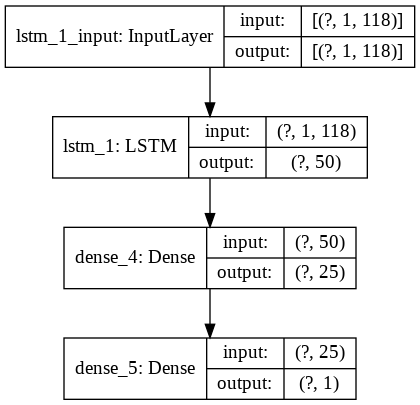

In [72]:
keras.utils.plot_model(model_clima,"model_clima.png",show_shapes = True)

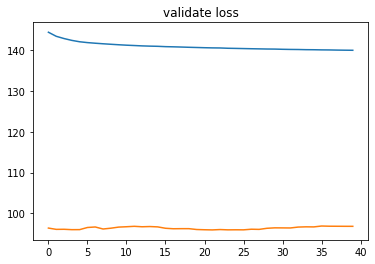

In [73]:
y_results=model_clima.predict(x_test)
plt.plot(history_clima.history['loss'])
plt.title('loss')
plt.plot(history_clima.history['val_loss'])
plt.title('validate loss')
plt.show()

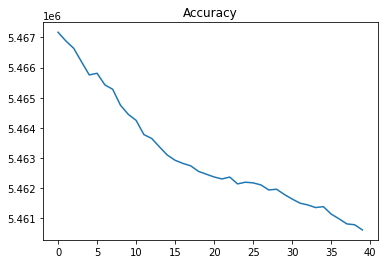

In [74]:
plt.title('Accuracy')
plt.plot(history.history['MSE'])
plt.show()

In [75]:
compara_lstm_clima = pd.DataFrame(np.array([y_test.reshape(22555), [x[0] for x in y_results.reshape(22555,1)]])).transpose()
compara_lstm_clima.columns = ['real', 'prediccion']

#inverted = scaler.inverse_transform(compara.values)

compara2_lstm_clima = pd.DataFrame(compara_lstm_clima)
compara2_lstm_clima.columns = ['real', 'prediccion']
compara2_lstm_clima['diferencia'] = compara2_lstm_clima['real'] - compara2_lstm_clima['prediccion']

In [76]:
compara2_lstm_clima.describe()

,real,prediccion,diferencia
count,22555.000000,22555.000000,22555.000000
mean,20.308262,-3.874533,24.182795
std,858.481150,13.082688,858.447588
min,-78.970000,-126.883987,-204.740307
25%,-2.843333,-8.202224,-1.293787
50%,0.050000,-2.569037,3.154943
75%,2.510000,0.410571,10.654276
max,49451.660000,231.063965,49467.804810


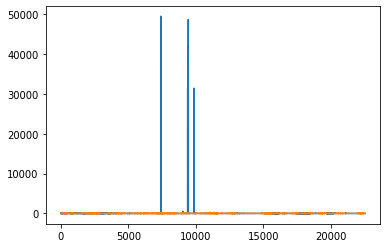

In [77]:
compara2_lstm_clima['real'].plot()
compara2_lstm_clima['prediccion'].plot()

In [78]:
model_clima.save('/content/drive/My Drive/LSTM_clima.h5')
json_config = model.to_json()
with open('/content/drive/My Drive/LSTM_clima.json', 'w') as json_file:
    json_file.write(json_config)

<div class="alert alert-block alert-warning">
    <h3><center>Observaciones</center></h3>
    <p align="right"/>
    <ul>
        <li>¿Cómo manejas el data leakage en este caso?</li>
Mantener los datos actualizados, sin importar que estén 'sucios', yo crearía una función para ir actualizando los datos rapidamente y de manera eficiente, también la base de datos podría crecer agregando mas atributos como la información de los clientes.
<li>¿Cuánto mejora la capacidad predictiva del modelo?</li>
En este caso no mejoró la capacidad predictiva del modelo al no poder identificar las variables mas importantes para su desempeño
        <li>¿Cuáles variables son las más importantes?</li>
Según lo observado, las variables mas importantes eran la fecha, la subestacion, la hora, el mes, dia de la semana y si era fin de semana o no.
        </ul>
 </div>

<div class="alert alert-block alert-info">
    <h2><center>Reflexión</center></h2>
    <p align="right"/>   
- ¿Por qué sería bueno utilizar un modelo como este para anticiparse a desvíos de precios de la energía?

Porque se intenta realizar un pronostico de un dato a futuro, y las redes neuronales son modelos sumamente maleables a diferentes necesidades y son resistentes a ruido, por lo que los datos no tendrían que llegar precisamente perfectos del data leakage

- ¿Qué casos de uso te imaginas podrían beneficiarse teniendo acceso a un modelo como este?

De este modelo podrían beneficiarse los proveedores del servicio, ya que podrían saber cual deberian ser los costos programados correctos del día siguiente.

  Este es un modelo que claramente se desempeñaría mejor con la construcción de una serie de tiempo pura, si se quisiera utilizar una red como LSTM yo recomendaría hacer embeddings con las variables categoricas y observar si la red es mejor para encontrar relaciones.
</div>

